# Further applications: data augmentation for histological images
This notebook shows how the biscuit optimization problem can be applied to the problem of data augmentation, i.e. the generation of realistic synthetic data to improve the training of machine learning systems.

In particular, previous heuristics will be applied to image augmentation in biomedical images which benefit most from this process as obtaining samples can be hard or very expensive.

Images are taken from public datasets available at [https://www.kaggle.com/competitions/data-science-bowl-2018/data](https://www.kaggle.com/competitions/data-science-bowl-2018/data)

## Inputs

In this case, the dough mask is an empty 256×256 image and cutters are single nuclei cut from larger images.

In [1]:
# Optimization Project: Biscuit Optimizer
# Roberto Basla
# Politecnico di Milano
# A.Y. 2021/2022

import os
import numpy as np
from pprint import pprint

import cv2
from typing import Any, Callable, Generator
from time import time
import matplotlib.pyplot as plt
import random

import sys
sys.path.append("..")
from utils import utils

## Inputs

In [2]:
nuclei_dir = "../../img/nuclei/"
image_shape = (256, 256)

In [3]:
samples = {}
for id in os.listdir(nuclei_dir):
	sample = {}
	masks_path = os.path.join(nuclei_dir, id,  "masks")
	image_path = os.path.join(nuclei_dir, id, "images")

	sample["image"] = cv2.imread(os.path.join(image_path, id + ".png"), cv2.IMREAD_GRAYSCALE)
	assert sample["image"] is not None, f"{id}, {os.path.join(image_path, id + '.png')}"
	masks = []
	for mask_filename in os.listdir(masks_path):
		masks.append(cv2.imread(os.path.join(masks_path, mask_filename), cv2.IMREAD_GRAYSCALE) > 0)
		assert masks[-1] is not None, f"{id}, {mask_filename}"
	sample["masks"] = np.stack(masks, axis=0)
	samples[id] = sample

## Nuclei specific functions

In [4]:
def enlarge_mask(mask, n_times):
	for i in range(n_times):
		mask = np.where(np.logical_or(*np.gradient(mask * 1)), 1, mask)
	return mask

def shrink_mask(mask, n_times):
	for i in range(n_times):
		new_mask = np.where(np.logical_or(*np.gradient(mask * 1)), 0, mask)
		if np.count_nonzero(new_mask) == 0:
			return mask
		mask = new_mask
	return mask

def modify_margin(mask, delta):
	if delta == 0:
		return mask
	if delta > 0:
		return enlarge_mask(mask, delta)
	return shrink_mask(mask, -delta)

In [5]:
def generate_from_samples(samples, image_shape, margin_range=None):
	nuclei_image = np.zeros(image_shape)
	bitmask = np.ones(image_shape)
	colored_mask = np.zeros(image_shape, dtype=np.uint8)

	failed_counter = 0
	nuclei_mask = []

	mask_num = 1
	while failed_counter < 5:
		id = random.choice(list(samples.keys()))
		sample = samples[id]
		mask_id = random.randint(0, sample["masks"].shape[0] - 1)
		
		full_mask = sample["masks"][mask_id]
		original_mask = utils.crop_image(full_mask)

		if margin_range is not None:
			full_mask = modify_margin(full_mask, random.randint(margin_range[0], margin_range[1]))
		
		mask = utils.crop_image(full_mask)
		y_diff = int((mask.shape[0] - original_mask.shape[0]) / 2)
		x_diff = int((mask.shape[1] - original_mask.shape[1]) / 2)

		y0, x0, y1, x1 = utils.crop_coordinates(sample["masks"][mask_id])
		cropped_image = sample["image"][y0:y1, x0:x1]
		available_coords = tuple((h, k) for h in range(image_shape[0]) for k in range(image_shape[1]) \
			if utils.can_host(bitmask, mask, h, k))
		if len(available_coords) > 0:
			failed_counter = 0
			n, m = random.choice(available_coords)
			bitmask[n:n+mask.shape[0], m:m+mask.shape[1]] = \
				np.logical_and(bitmask[n:n+mask.shape[0], m:m+mask.shape[1]], np.logical_not(mask))

			start_y = n + y_diff
			start_x = m + x_diff

			old_patch = nuclei_image[max(start_y, 0):start_y+cropped_image.shape[0],
				max(start_x, 0):start_x+cropped_image.shape[1]]
			new_patch = np.where(original_mask, cropped_image, 0)[:old_patch.shape[0], :old_patch.shape[1]]
			nuclei_image[max(start_y, 0):start_y+cropped_image.shape[0], 
				max(start_x, 0):start_x+cropped_image.shape[1]] = np.where(np.logical_xor(old_patch, new_patch),
					old_patch + new_patch,
					np.average([old_patch, new_patch], axis=0)
				)

			mask_layer = np.zeros(image_shape)
			mask_layer[max(start_y, 0):start_y+cropped_image.shape[0], max(start_x, 0):start_x+cropped_image.shape[1]] = \
				np.where(original_mask, 255, 0)[:old_patch.shape[0], :old_patch.shape[1]]
			nuclei_mask.append(mask_layer)

			old_patch = colored_mask[max(start_y, 0):start_y+cropped_image.shape[0], max(start_x, 0):start_x+cropped_image.shape[1]]
			new_patch = np.where(original_mask, mask_num, 0)[:old_patch.shape[0], :old_patch.shape[1]]
			colored_mask[max(start_y, 0):start_y+cropped_image.shape[0], max(start_x, 0):start_x+cropped_image.shape[1]] = \
				np.where(np.logical_xor(old_patch, new_patch),
					old_patch + new_patch,
					np.average([old_patch, new_patch], axis=0)
				)

			colored_mask[n:n+mask.shape[0], m:m+mask.shape[1]] = np.where(mask, mask_num, colored_mask[n:n+mask.shape[0], m:m+mask.shape[1]])
			mask_num += 1
		else:
			failed_counter += 1
	nuclei_image = np.where(nuclei_image == 0, np.random.normal(scale=4, size=image_shape), nuclei_image)
	nuclei_mask = np.stack(nuclei_mask)
	return nuclei_image, colored_mask

In [6]:
def show_augmentation(nuclei_image, colored_mask, title):
	plt.imshow(nuclei_image, cmap="gray")
	plt.axis("off")
	plt.show()

	plt.imshow(colored_mask)
	plt.axis("off")
	plt.show()

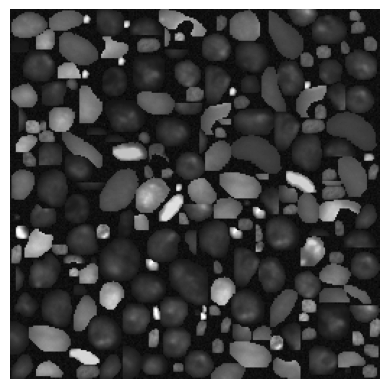

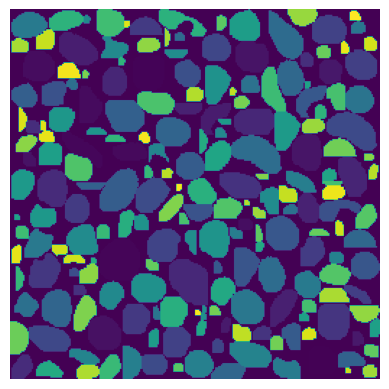

In [7]:
nuclei_image, colored_mask = generate_from_samples(samples, image_shape)
show_augmentation(nuclei_image, colored_mask, "Random strategy")

## Margin modifications

0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 282


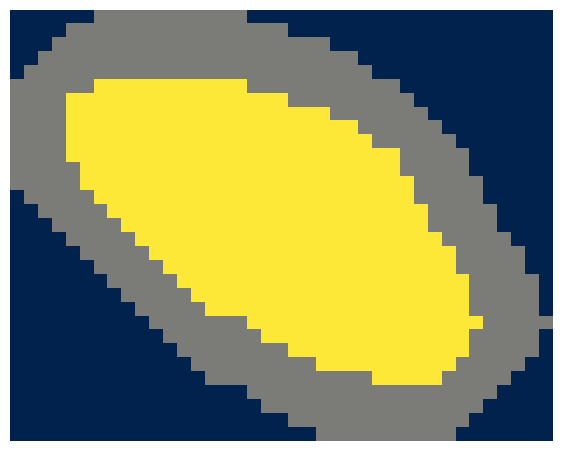

In [8]:
id = random.choice(list(samples.keys()))
sample = samples[id]
mask_id = random.randint(0, sample["masks"].shape[0] - 1)

full_mask = sample["masks"][mask_id]
print(id, mask_id)
processed_mask = modify_margin(full_mask, 5)
y0, x0, y1, x1 = utils.crop_coordinates(processed_mask)

mask = processed_mask[y0:y1, x0:x1]
original_mask = full_mask[y0:y1, x0:x1]

plt.figure(figsize=(7, 7))
plt.imshow(np.where(original_mask, 255, np.where(mask, 127, 0)), cmap="cividis")
plt.axis("off")
plt.show()

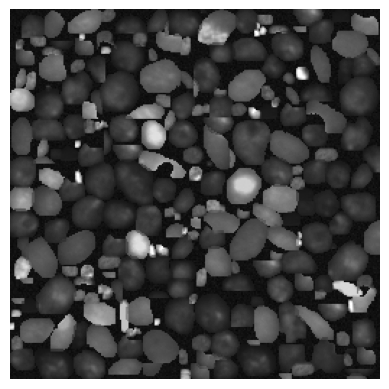

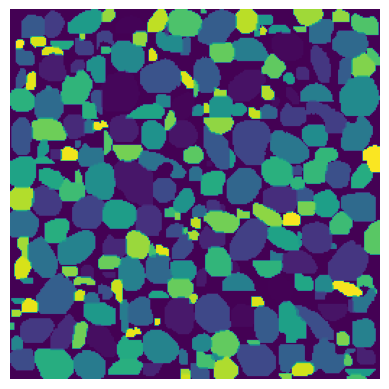

In [9]:
nuclei_image, colored_mask = generate_from_samples(samples, image_shape, margin_range=(-1, -1))
show_augmentation(nuclei_image, colored_mask, "Lowered margin")

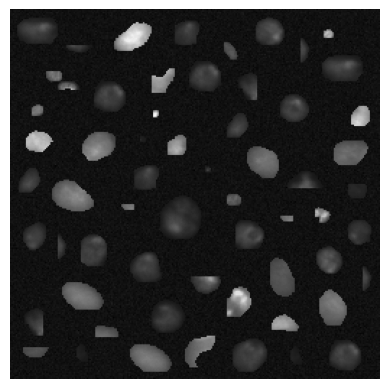

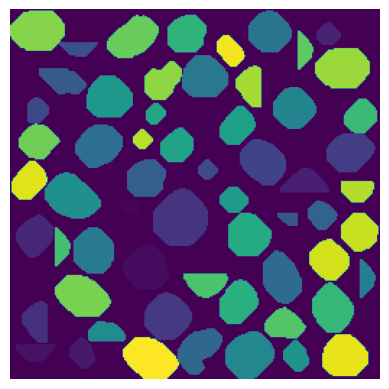

In [10]:
nuclei_image, colored_mask = generate_from_samples(samples, image_shape, margin_range=(5, 5))
show_augmentation(nuclei_image, colored_mask, "Increased margin")

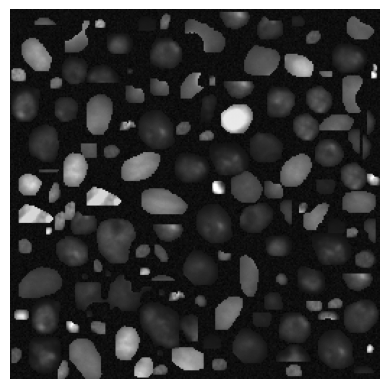

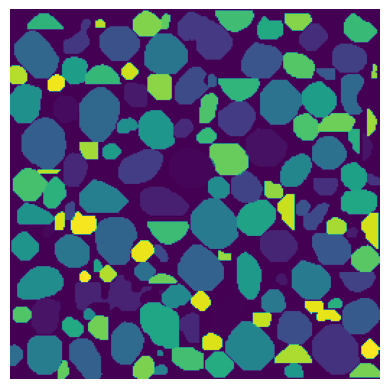

In [11]:
nuclei_image, colored_mask = generate_from_samples(samples, image_shape, margin_range=(-1, 5))
show_augmentation(nuclei_image, colored_mask, "Random margin")